## Cardiovascular Disease Project <br>
### By Group 5<br>
Austin Dickerson - SN 2729612  <br>
Irakliy Marsagishvili - SN 2637597 <br>
Sanne de Wilde - SN 2650188 <br>

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from scipy import stats
import datetime
import sys
from io import StringIO
import statsmodels.api as sm
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

### Data Preparation

In [2]:
#This code preprocesses the data to add BMI and make one hot versions of some variables

cardiodf = pd.read_csv('cardio_train.csv', delimiter=';')
explncontdf = pd.DataFrame(cardiodf[['age','height','weight','ap_hi','ap_lo','cholesterol','gluc']])
explncontdf['BMI'] = round(explncontdf['weight']/((explncontdf['height']/100)**2),2)
expln1hotdf = pd.DataFrame(cardiodf[['smoke','alco','active']])
expln1hotdf['gender_1'] = (cardiodf['gender']-1)
expln1hotdf['gender_2'] = (cardiodf['gender']%2)
target = pd.DataFrame(cardiodf['cardio'])


df = cardiodf.copy()
df = pd.DataFrame(df)
df['age']=df['age']//365
df['BMI'] = round(df.weight / (df.height**2)  * 10000, 2)
df['gender_1'] = (df['gender']-1)
df['gender_2'] = (df['gender']%2)
df_2 = df.copy()


In [3]:

print(df)

          id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0   50       2     168    62.0    110     80            1     1   
1          1   55       1     156    85.0    140     90            3     1   
2          2   51       1     165    64.0    130     70            3     1   
3          3   48       2     169    82.0    150    100            1     1   
4          4   47       1     156    56.0    100     60            1     1   
...      ...  ...     ...     ...     ...    ...    ...          ...   ...   
69995  99993   52       2     168    76.0    120     80            1     1   
69996  99995   61       1     158   126.0    140     90            2     2   
69997  99996   52       2     183   105.0    180     90            3     1   
69998  99998   61       1     163    72.0    135     80            1     2   
69999  99999   56       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio    BMI  gender_1  gender_2  

### Data Analysis and Visualisation

In [4]:
#set up DF
df['pressure_difference'] = df.ap_hi - df.ap_lo  

for i in df.index:
    if df['BMI'][i] > 100:
        df = df.drop(i)
        
for i in df.index:
    if ((df['pressure_difference'][i]<0) or (df['pressure_difference'][i]>100)):
        df = df.drop(i)
        
age_stats = df['age'].describe()
bmi_stats = df['BMI'].describe()
pressure_stats = df['pressure_difference'].describe()

print(age_stats)
print(bmi_stats)
print(pressure_stats)


count    68592.000000
mean        52.827341
std          6.769143
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64
count    68592.000000
mean        27.464584
std          5.291033
min          3.470000
25%         23.880000
50%         26.350000
75%         30.120000
max         95.220000
Name: BMI, dtype: float64
count    68592.000000
mean        45.297032
std         11.467591
min          0.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        100.000000
Name: pressure_difference, dtype: float64


In [5]:
#women df
women_df = df[df.gender == 1]
age_stats_w = women_df['age'].describe()
bmi_stats_w = women_df['BMI'].describe()
pressure_stats_w = women_df['pressure_difference'].describe()

print(age_stats_w)
print(bmi_stats_w)
print(pressure_stats_w)

count    44682.000000
mean        52.942550
std          6.670119
min         29.000000
25%         49.000000
50%         54.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64
count    44682.000000
mean        27.884384
std          5.631880
min          8.000000
25%         23.880000
50%         26.670000
75%         30.860000
max         86.780000
Name: BMI, dtype: float64
count    44682.000000
mean        45.010653
std         11.433326
min          0.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        100.000000
Name: pressure_difference, dtype: float64


In [6]:
#men df

men_df = df[df.gender == 2]
age_stats_m = men_df['age'].describe()
bmi_stats_m = men_df['BMI'].describe()
pressure_stats_m = men_df['pressure_difference'].describe()
print(age_stats_m)
print(bmi_stats_m)
print(pressure_stats_m)

count    23910.000000
mean        52.612045
std          6.945433
min         29.000000
25%         47.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64
count    23910.000000
mean        26.680080
std          4.482606
min          3.470000
25%         23.762500
50%         25.895000
75%         29.030000
max         95.220000
Name: BMI, dtype: float64
count    23910.000000
mean        45.832204
std         11.512511
min          0.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        100.000000
Name: pressure_difference, dtype: float64


Average age of Men:  52.9425495725348
Average age of Women:  52.6120451693852


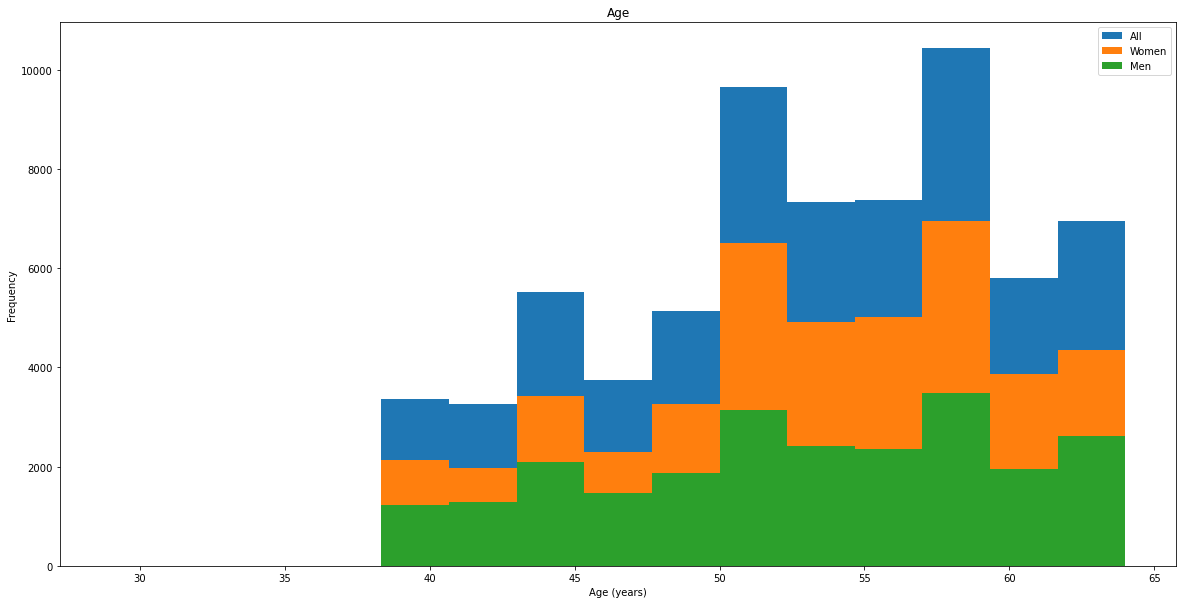

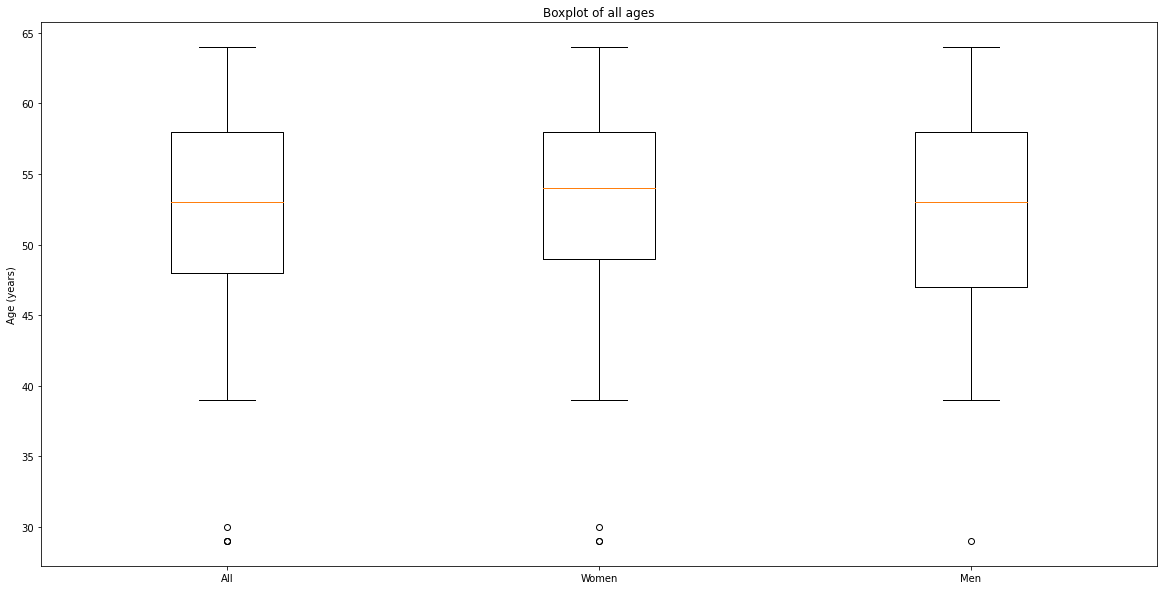

In [7]:
#histogram with ages male and female.
ages = df['age'].tolist()
ages_histo = plt.hist(ages,bins = 15)
women_ages =women_df['age'].tolist()

women_average = sum(women_ages)/len(women_ages)
women_histo = plt.hist(women_ages, bins=15)
men_ages = men_df['age'].tolist()
men_average = sum(men_ages)/len(men_ages)
print('Average age of Men: ',women_average)
print('Average age of Women: ', men_average)
plt.hist(men_ages,bins=15)
plt.title('Age')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.gca().legend(('All','Women','Men'))
plt.show()
all_ages=[ages, women_ages,men_ages]
plt.boxplot(all_ages, notch=None, patch_artist=None, widths=None)
plt.title('Boxplot of all ages')
plt.ylabel('Age (years)')
plt.xticks([1, 2, 3], ['All', 'Women', 'Men'])
plt.show()

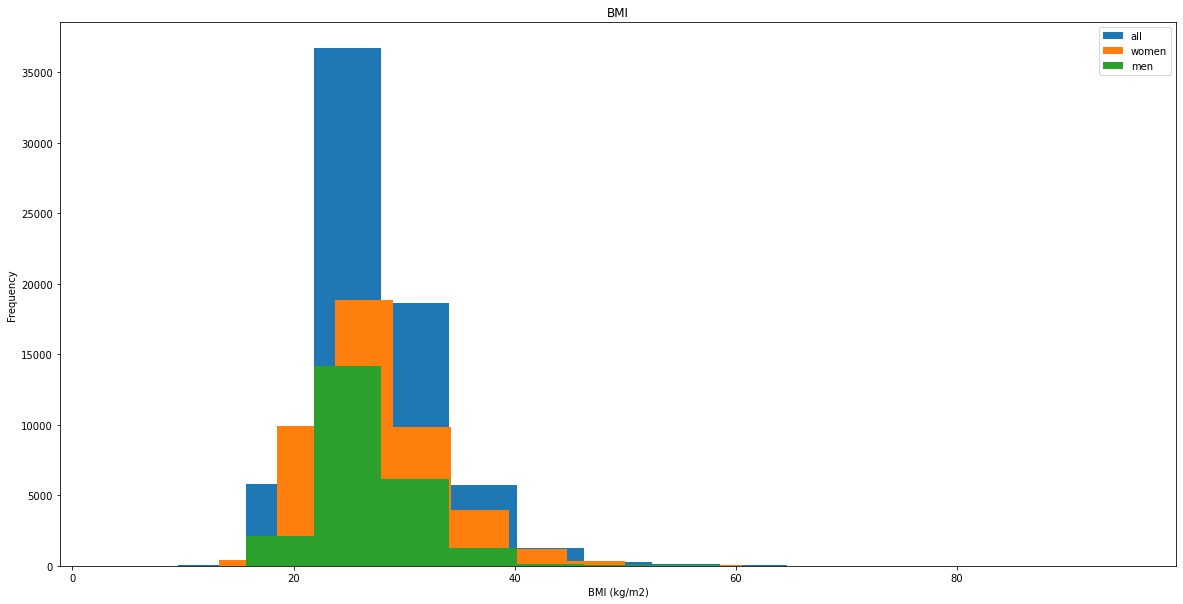

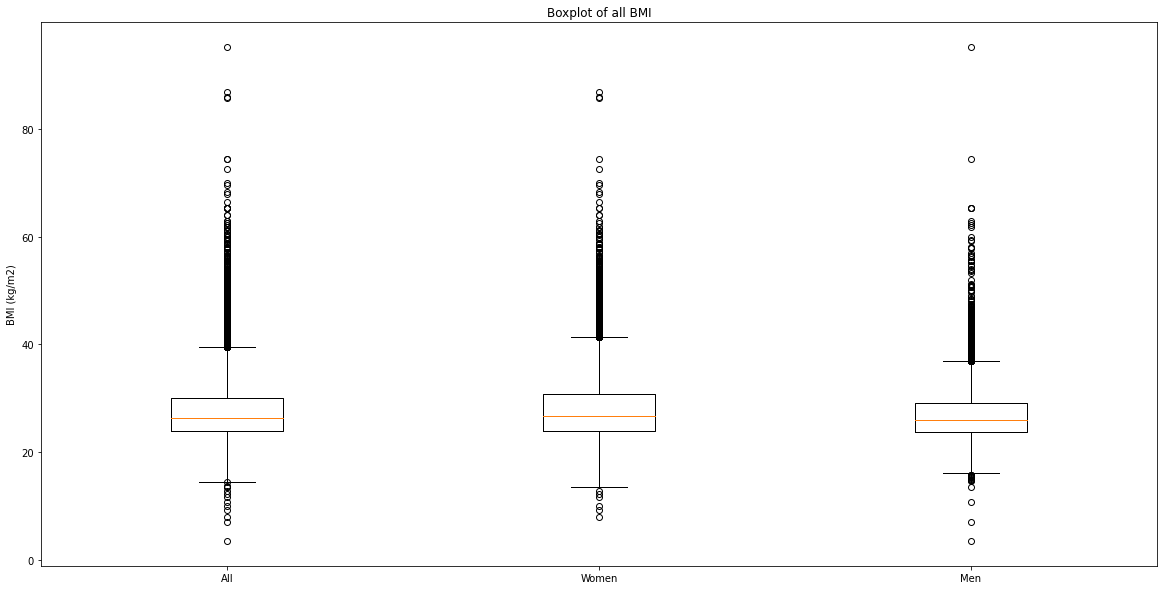

In [8]:
#visualizations of BMI
bmi = df['BMI'].tolist()
plt.hist(bmi, bins=15)
women_bmi = women_df['BMI'].tolist()
plt.hist(women_bmi, bins=15)
men_bmi = men_df['BMI'].tolist()
plt.hist(men_bmi, bins=15)
plt.title('BMI')
plt.xlabel('BMI (kg/m2)')
plt.ylabel('Frequency')
plt.gca().legend(('all','women','men'))
plt.show()
all_bmi = [bmi,women_bmi, men_bmi]
plt.boxplot(all_bmi, notch=None, vert=None, patch_artist=None, widths=None)
plt.title('Boxplot of all BMI')
plt.ylabel('BMI (kg/m2)')
plt.xticks([1, 2, 3], ['All', 'Women', 'Men'])
plt.show()

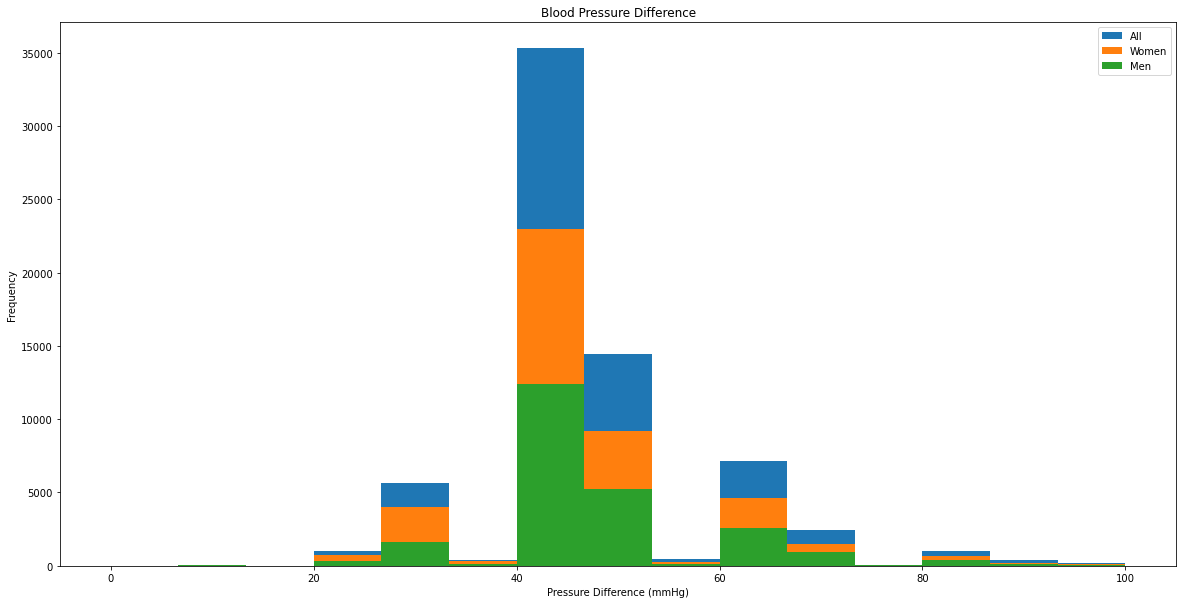

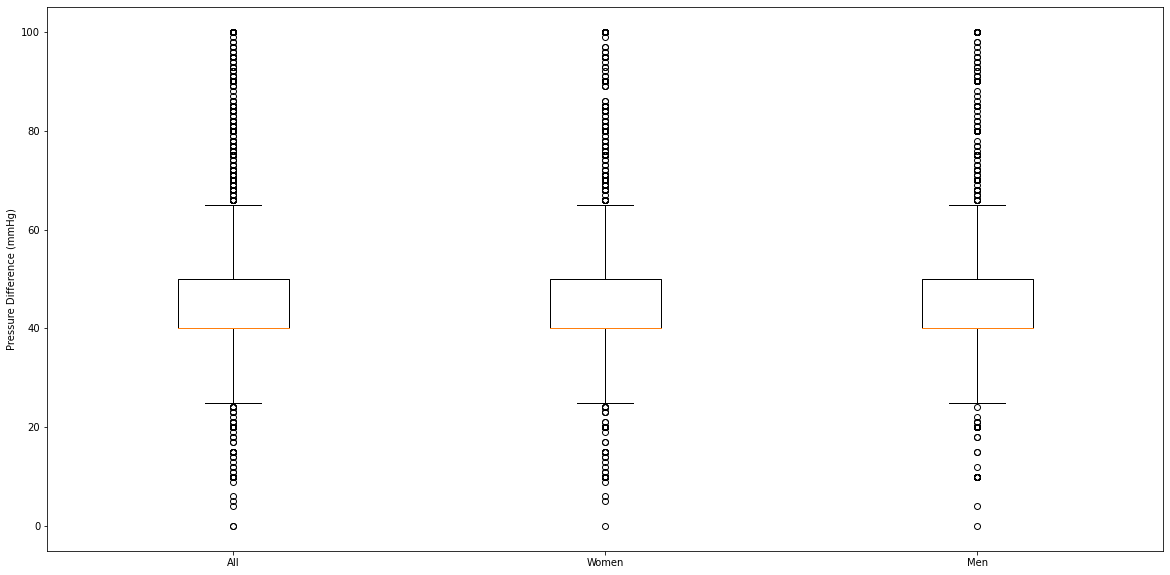

In [9]:
# Histograms for pressure difference
#max pressure difference cannot be that high, so filtering all above 100

# https://www.healthline.com/health/pulse-pressure#low-vs-normal-vs-high

pressure = df['pressure_difference'].tolist()
plt.hist(pressure, bins=15)
women_pressure = women_df['pressure_difference'].tolist()
plt.hist(women_pressure, bins=15)
men_pressure = men_df['pressure_difference'].tolist()
plt.hist(men_pressure, bins=15)
plt.title('Blood Pressure Difference')
plt.xlabel('Pressure Difference (mmHg)')
plt.ylabel('Frequency')
plt.gca().legend(('All','Women','Men'))
plt.show()
all_pressure = [pressure,women_pressure, men_pressure]
plt.boxplot(all_pressure, notch=None, vert=None, patch_artist=None, widths=None)
plt.ylabel('Pressure Difference (mmHg)')
plt.xticks([1, 2, 3], ['All', 'Women', 'Men'])
plt.show()

In [10]:
#counting method
def frequency_table(df, column):
    freq_table = pd.crosstab(index=df[column], columns="count") 
    return freq_table


In [11]:
frequency_table(women_df, 'cholesterol')

col_0,count
cholesterol,
1,33013
2,6244
3,5425


In [12]:
frequency_table(men_df, 'cholesterol')

col_0,count
cholesterol,
1,18442
2,3039
3,2429


In [13]:
frequency_table(women_df, 'smoke')

col_0,count
smoke,
0,43889
1,793


In [14]:
frequency_table(men_df, 'smoke')

col_0,count
smoke,
0,18671
1,5239


In [15]:
frequency_table(women_df, 'alco')

col_0,count
alco,
0,43555
1,1127


In [16]:
frequency_table(men_df, 'alco')

col_0,count
alco,
0,21379
1,2531


In [17]:
frequency_table(women_df, 'cardio')

col_0,count
cardio,
0,22715
1,21967


In [18]:
frequency_table(men_df, 'cardio')

col_0,count
cardio,
0,11969
1,11941


In [19]:
def test_significance(p_value):
    if p_value <0.05:
        result = 'significant difference'
    else:
        result = 'no significant difference'
    return result

def perform_tests(df, column):
    sick  =df[df['cardio']==1]
    non_sick = df[df['cardio']==0]
    
    p_value = stats.ranksums(sick[column],non_sick[column]).pvalue
    diff = test_significance (p_value)
        
    return diff

In [20]:
perform_tests(women_df,'age')

'significant difference'

In [21]:
perform_tests(men_df,'age')

'significant difference'

In [22]:
perform_tests(women_df,'BMI')

'significant difference'

In [23]:
perform_tests(men_df, 'BMI')

'significant difference'

In [24]:
perform_tests(women_df, 'pressure_difference')

'significant difference'

In [25]:
perform_tests(men_df, 'pressure_difference')

'significant difference'

In [26]:
def separate_data(results):
    diffs = []
    ages = []
    for i in results:
        diffs.append(i[0])
        ages.append(i[1])
    return diffs, ages

def separate_data_3(results):
    diffs = []
    diffs_2 = []
    ages = []
    for i in results:
        diffs.append(i[0])
        diffs_2.append(i[1])
        ages.append(i[2])
    return diffs, diffs_2, ages



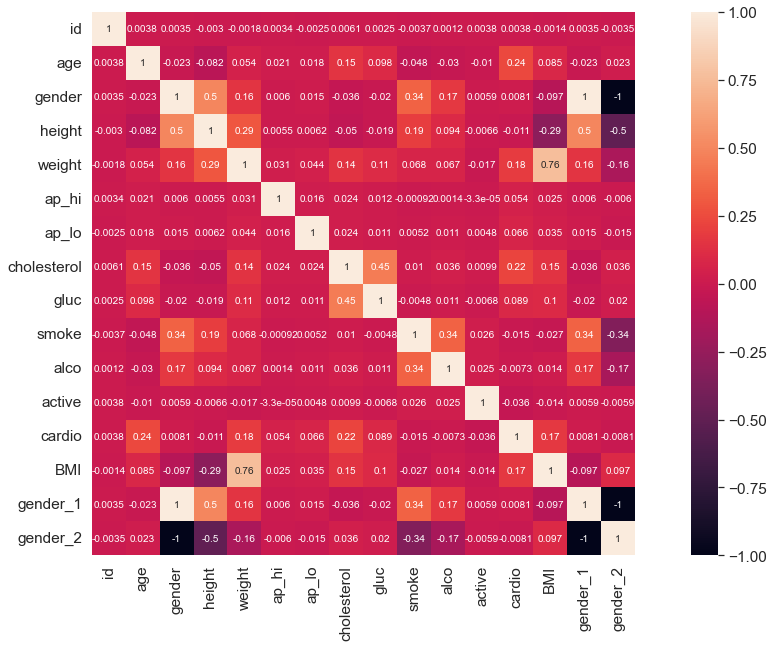

In [27]:
def make_a_corr(df):
    candidates = [col for col in df.columns if col!= 'Unnamed: 0']
    curry = df[candidates].corr()
    sns.set(font_scale = 1.4)
    sns.heatmap(curry, square = True, annot = True, annot_kws={'size':10})

make_a_corr(df_2)


In [28]:
df_2[['cardio', 'age', 'cholesterol', 'weight', 'BMI']].corr()

,cardio,age,cholesterol,weight,BMI
cardio,1.000000,0.237985,0.221147,0.181660,0.165633
age,0.237985,1.000000,0.154012,0.053561,0.085403
cholesterol,0.221147,0.154012,1.000000,0.141768,0.146268
weight,0.181660,0.053561,0.141768,1.000000,0.762002
BMI,0.165633,0.085403,0.146268,0.762002,1.000000


In [29]:
'''avg BMI of ppl with cardio '''
def avg_of_BMI(df, gender):
    if gender == 'male':
        result =  df.loc[df.gender_2 == 1].loc[df.cardio == 1].BMI.mean()
        # bmis_avg.append(round(result, 2))
        return result
    elif gender == 'female':
        result = df.loc[df.gender_1 == 1].loc[df.cardio == 1].BMI.mean()
        # bmis_avg.append(round(result, 2))
        return result
    else:
        result = df.loc[df.cardio == 1].BMI.mean()
        # bmis_avg.append(round(result, 2))
        return result

print('Average BMI of Men with Cardiovascular Disease: ',round(avg_of_BMI(df_2, 'male'), 2))
print('Average BMI of Women with Cardiovascular Disease: ', round(avg_of_BMI(df_2, 'female'), 2))
print('Average BMI of Total with Cardiovascular Disease: ', round(avg_of_BMI(df_2, 'mmmm'), 2))

def avg_of_BMI_no(df, gender):
    if gender == 'male':
        result =  df.loc[df.gender_2 == 1].loc[df.cardio == 0].BMI.mean()
        # bmis_avg.append(round(result, 2))
        return result
    elif gender == 'female':
        result = df.loc[df.gender_1 == 1].loc[df.cardio == 0].BMI.mean()
        # bmis_avg.append(round(result, 2))
        return result
    else:
        result = df.loc[df.cardio == 0].BMI.mean()
        # bmis_avg.append(round(result, 2))
        return result

print('\n')
print('Average BMI of Men with no Cardiovascular Disease: ',round(avg_of_BMI_no(df_2, 'male'), 2))
print('Average BMI of Women with no Cardiovascular Disease: ', round(avg_of_BMI_no(df, 'female'), 2))
print('Average BMI of Total with no Cardiovascular Disease: ', round(avg_of_BMI_no(df_2, 'mmmm'), 2))
# print(bmis_avg)


Average BMI of Men with Cardiovascular Disease:  29.1
Average BMI of Women with Cardiovascular Disease:  27.59
Average BMI of Total with Cardiovascular Disease:  28.57


Average BMI of Men with no Cardiovascular Disease:  26.89
Average BMI of Women with no Cardiovascular Disease:  25.83
Average BMI of Total with no Cardiovascular Disease:  26.55


In [30]:
def avg_of_age(df, gender):
    if gender == 'male':
        return df.loc[df.gender_2 == 1].loc[df.cardio == 1].age.mean()
    elif gender == 'female':
        return df.loc[df.gender_1 == 1].loc[df.cardio == 1].age.mean()
    else:
        return df.loc[df.cardio == 1].age.mean()
    
def min_of_age(df, gender):
    if gender == 'male':
        return df.loc[df.gender_2 == 1].loc[df.cardio == 1].age.min()
    elif gender == 'female':
        return df.loc[df.gender_1 == 1].loc[df.cardio == 1].age.min()
    else:
        return df.loc[df.cardio == 1].age.min()

print('Min age of Men with Cardiovascular Disease: ',round(min_of_age(df_2, 'male'), 0))
print('Min age of Women with Cardiovascular Disease: ', round(min_of_age(df_2, 'female'), 0))
print('Min age of Total with Cardiovascular Disease: ', round(min_of_age(df_2, 'mmmm'), 0))
print('\n')
print('Average age of Men with Cardiovascular Disease: ',round(avg_of_age(df_2, 'male'), 0))
print('Average age of Women with Cardiovascular Disease: ', round(avg_of_age(df_2, 'female'), 0))
print('Average age of Total with Cardiovascular Disease: ', round(avg_of_age(df_2, 'mmmm'), 0))


def avg_of_age_no(df, gender):
    if gender == 'male':
        return df.loc[df.gender_2 == 1].loc[df.cardio == 0].age.mean()
    elif gender == 'female':
        return df.loc[df.gender_1 == 1].loc[df.cardio == 0].age.mean()
    else:
        return df.loc[df.cardio == 0].age.mean()
    
def min_of_age_no(df, gender):
    if gender == 'male':
        return df.loc[df.gender_2 == 1].loc[df.cardio == 0].age.min()
    elif gender == 'female':
        return df.loc[df.gender_1 == 1].loc[df.cardio == 0].age.min()
    else:
        return df.loc[df.cardio == 0].age.min()
print('\n')
print('Min age of Men with no Cardiovascular Disease: ',round(min_of_age_no(df_2, 'male'), 0))
print('Min age of Women with no Cardiovascular Disease: ', round(min_of_age_no(df_2, 'female'), 0))
print('Min age of Total with no Cardiovascular Disease: ', round(min_of_age_no(df_2, 'mmmm'), 0))
print('\n')
print('Average age of Men with no Cardiovascular Disease: ',round(avg_of_age_no(df_2, 'male'), 0))
print('Average age of Women with no Cardiovascular Disease: ', round(avg_of_age_no(df_2, 'female'), 0))
print('Average age of Total with no Cardiovascular Disease: ', round(avg_of_age_no(df_2, 'mmmm'), 0))


Min age of Men with Cardiovascular Disease:  39
Min age of Women with Cardiovascular Disease:  39
Min age of Total with Cardiovascular Disease:  39


Average age of Men with Cardiovascular Disease:  55.0
Average age of Women with Cardiovascular Disease:  54.0
Average age of Total with Cardiovascular Disease:  54.0


Min age of Men with no Cardiovascular Disease:  29
Min age of Women with no Cardiovascular Disease:  29
Min age of Total with no Cardiovascular Disease:  29


Average age of Men with no Cardiovascular Disease:  51.0
Average age of Women with no Cardiovascular Disease:  51.0
Average age of Total with no Cardiovascular Disease:  51.0


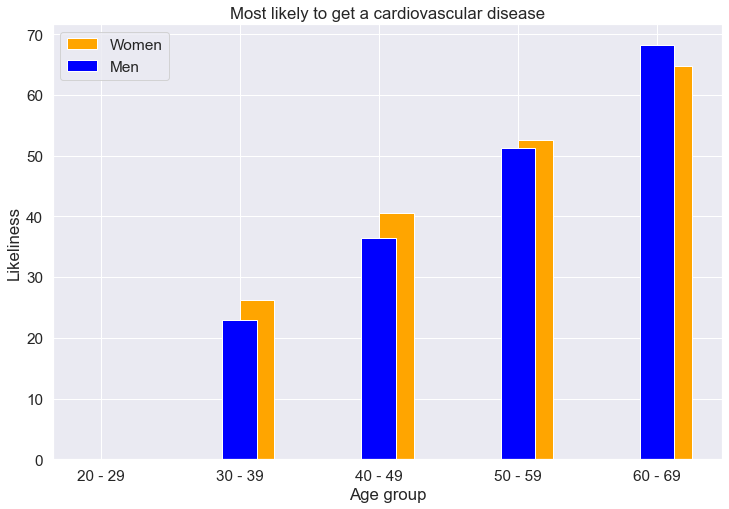

In [31]:
def likely_cardio(df):
    mini = int(df['age'].min())
    if(mini % 10 != 0):
        mini = int(mini - (mini % 10))
    
    maxi = int(df['age'].max())
    if(maxi % 10 != 0):
        maxi = int(maxi + (10 - (maxi % 10)))
    # print(maxi)
    results = []

    for i in range(mini, maxi, 10):
        mm = len(df.loc[df.age >= i].loc[df.age < i + 10 ])
        om = len(df.loc[df.age >= i].loc[df.age < i + 10 ].loc[df.cardio == 1])
        temp = om / mm * 100
        results.append([round(temp,1),  str(i) + ' - ' + str(i+9)])
    return results

ooo, mmm = separate_data(likely_cardio(df_2.loc[df_2.gender_2 == 1]))

sss, mmm = separate_data(likely_cardio(df_2.loc[df_2.gender_1 == 1]))
plt.subplots(figsize =(12, 8))

plt.bar(mmm, sss, color = 'orange', width = 0.25, align= 'edge', label = 'Women')
plt.bar(mmm, ooo, color = 'blue', width = 0.25, label = 'Men')


plt.ylabel("Likeliness")
plt.xlabel('Age group')
plt.title('Most likely to get a cardiovascular disease')
plt.legend()
plt.show()

In [32]:
def difference_blood(df):
    mmm = df.ap_hi - df.ap_lo
    return mmm.mean()

print('Average blood difference for everyone:', round(difference_blood(df_2), 0))
print('For Men: ', round(difference_blood(df_2.loc[df_2.gender_2 == 1])))
print('For Women: ', round(difference_blood(df_2.loc[df_2.gender_1 == 1])))

Average blood difference for everyone: 32.0
For Men:  34
For Women:  30


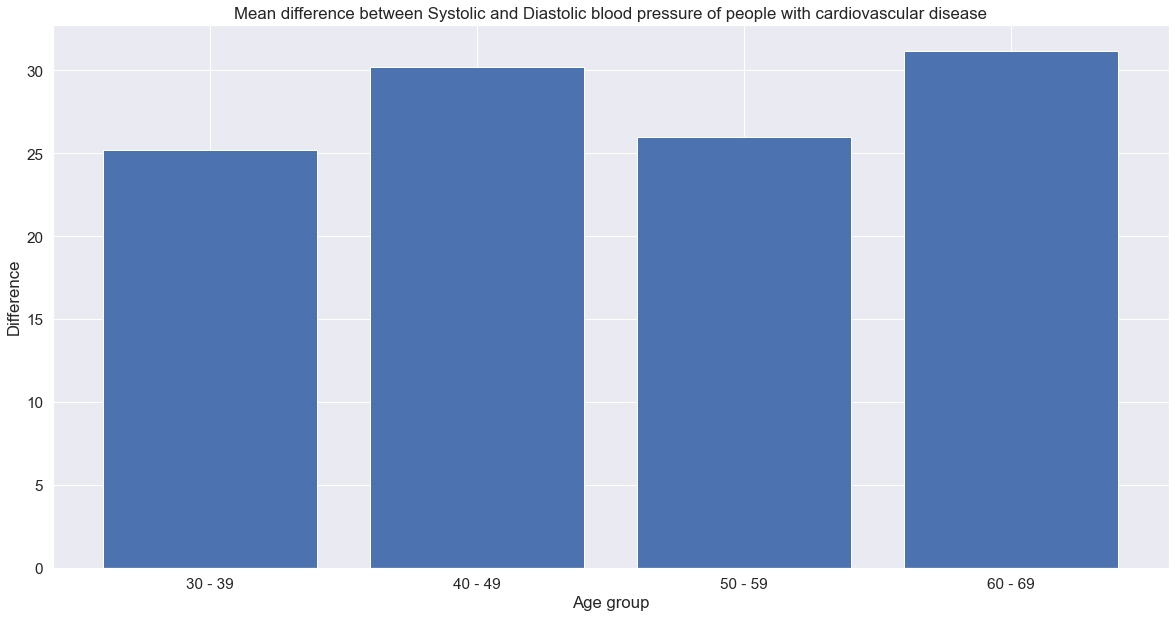

In [33]:
def dif_blood_age_groups_cardio(df):
    df = df.loc[df.cardio == 1]
    mini = int(df['age'].min())
    if(mini % 10 != 0):
        mini = int(mini - (mini % 10))
    
    maxi = int(df['age'].max())
    if(maxi % 10 != 0):
        maxi = int(maxi + (10 - (maxi % 10)))
    results = []

    for i in range(mini, maxi, 10):
        mm = difference_blood(df.loc[df.age >= i].loc[df.age < i + 10 ])
        results.append([round(mm,1),  str(i) + ' - ' + str(i+9)])
    return results



ddif, aages = separate_data(dif_blood_age_groups_cardio(df_2))

plt.bar(aages,ddif)
'''There is a difference between difference gaps between blood pressures of each age group'''
plt.ylabel("Difference")
plt.xlabel('Age group')
plt.title('Mean difference between Systolic and Diastolic blood pressure of people with cardiovascular disease')
plt.show()

In [34]:
print('Men:',dif_blood_age_groups_cardio(df_2.loc[df_2.gender_2 == 1]))
print('Women:',dif_blood_age_groups_cardio(df_2.loc[df_2.gender_1 == 1]))

Men: [[26.7, '30 - 39'], [29.6, '40 - 49'], [27.6, '50 - 59'], [32.1, '60 - 69']]
Women: [[23.0, '30 - 39'], [31.1, '40 - 49'], [22.7, '50 - 59'], [29.5, '60 - 69']]


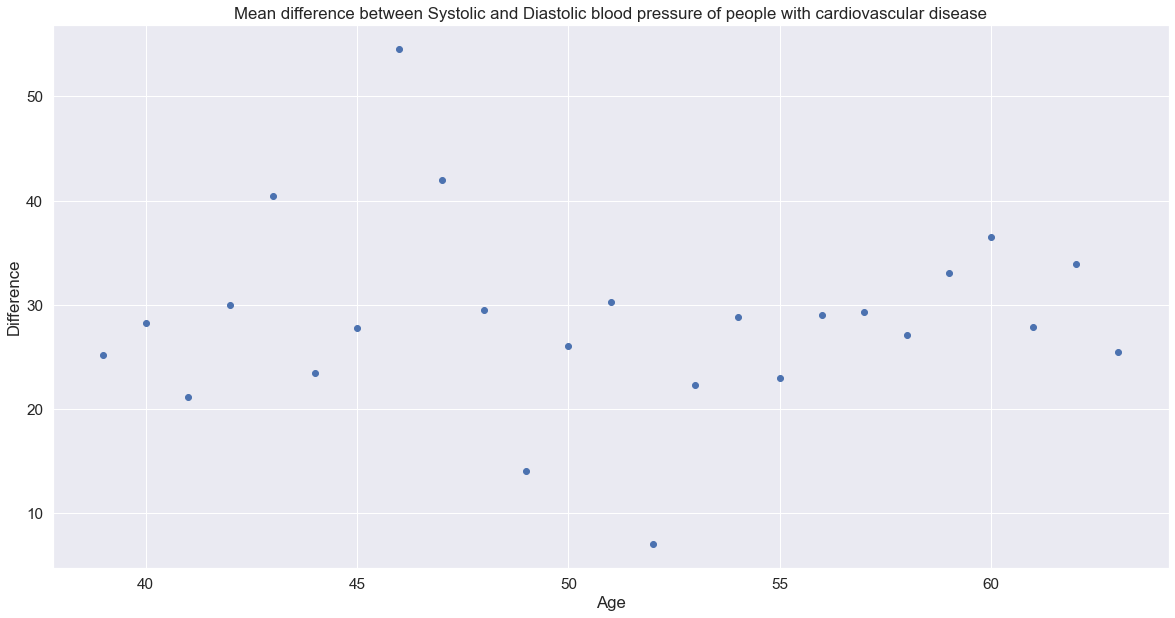

In [35]:
def dif_blood_all_ages_cardio(df):
    df = df.loc[df.cardio == 1]
    mini = int(df['age'].min())
 
    maxi = int(df['age'].max())
  
    results = []

    for i in range(mini, maxi):
        mm = difference_blood(df.loc[df.age == i])
        results.append([round(mm,1),  i])
    return results

aaa, bbb = separate_data(dif_blood_all_ages_cardio(df_2))
plt.scatter(bbb, aaa)
plt.ylabel("Difference")
plt.xlabel('Age')
plt.title('Mean difference between Systolic and Diastolic blood pressure of people with cardiovascular disease')
plt.show()

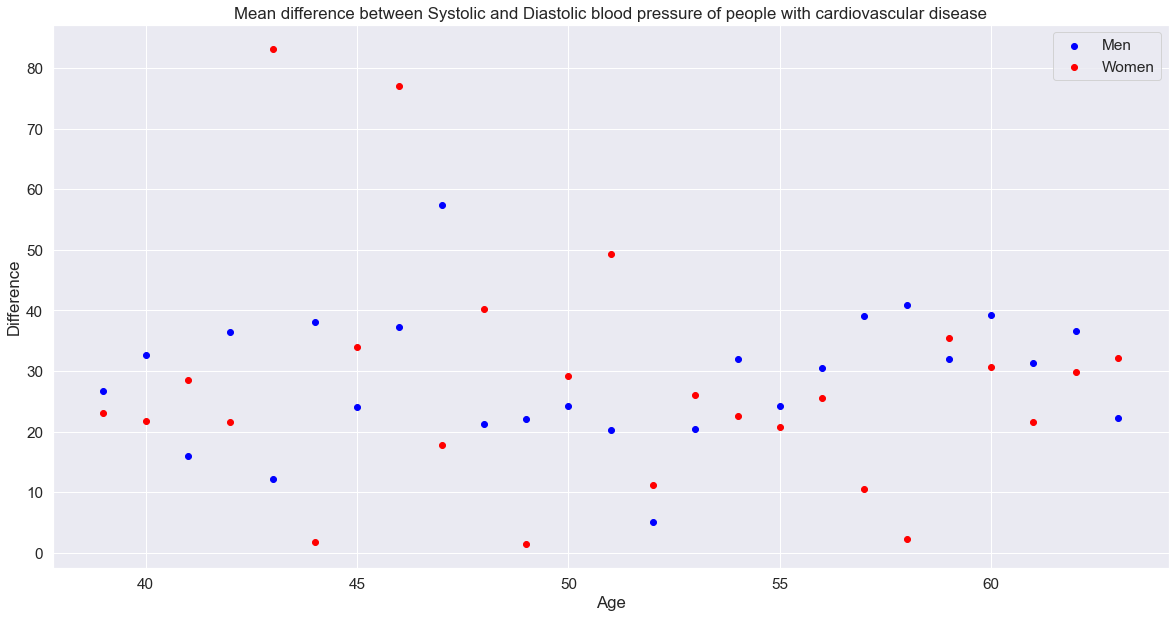

In [36]:
aaa, bbb = separate_data(dif_blood_all_ages_cardio(df_2.loc[df_2.gender_2 == 1]))
plt.scatter(bbb, aaa, c= 'blue', label = 'Men')
ccc, ddd = separate_data(dif_blood_all_ages_cardio(df_2.loc[df_2.gender_1 == 1]))

plt.scatter(ddd, ccc, c = 'red', label = 'Women')
plt.ylabel("Difference")
plt.xlabel('Age')
plt.title('Mean difference between Systolic and Diastolic blood pressure of people with cardiovascular disease')
plt.legend()
plt.show()

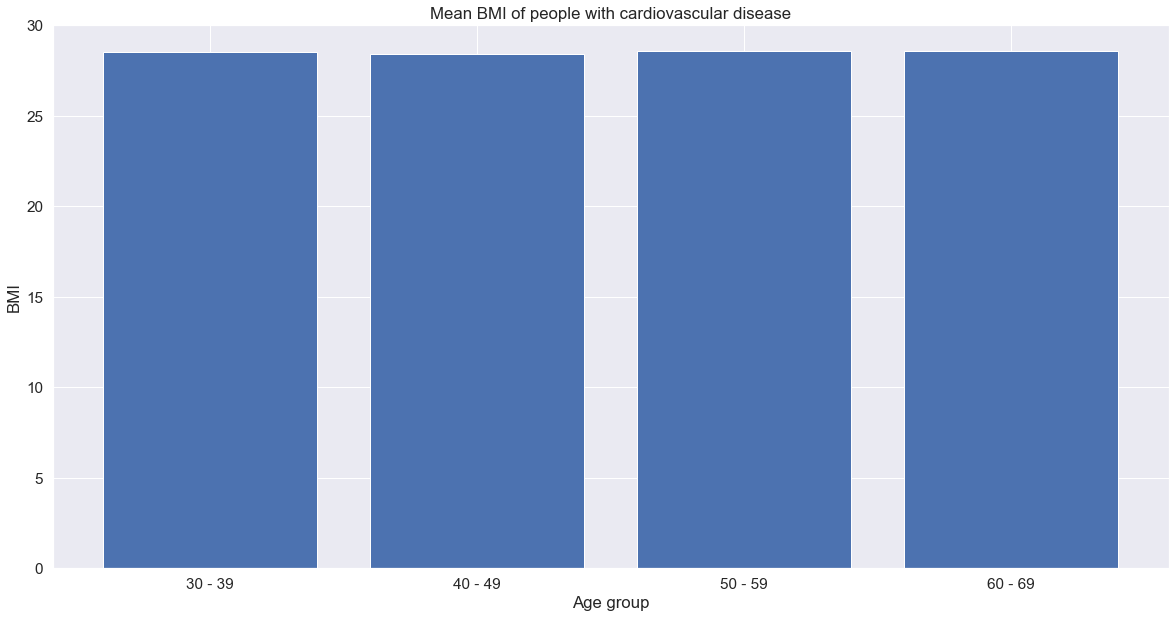

In [37]:
def avg_bmi_age_groups_cardio(df):
    df = df.loc[df.cardio == 1]
    mini = int(df['age'].min())
    if(mini % 10 != 0):
        mini = int(mini - (mini % 10))
    
    maxi = int(df['age'].max())
    if(maxi % 10 != 0):
        maxi = int(maxi + (10 - (maxi % 10)))
    results = []

    for i in range(mini, maxi, 10):
        mm = df.loc[df.age >= i].loc[df.age < i + 10 ].BMI.mean()
        results.append([round(mm,1), str(i) + ' - ' + str(i+9)])
    return results

ddif, aages = separate_data(avg_bmi_age_groups_cardio(df_2))
plt.bar(aages,ddif)
plt.ylabel("BMI")
plt.xlabel('Age group')
plt.title('Mean BMI of people with cardiovascular disease')
plt.show()


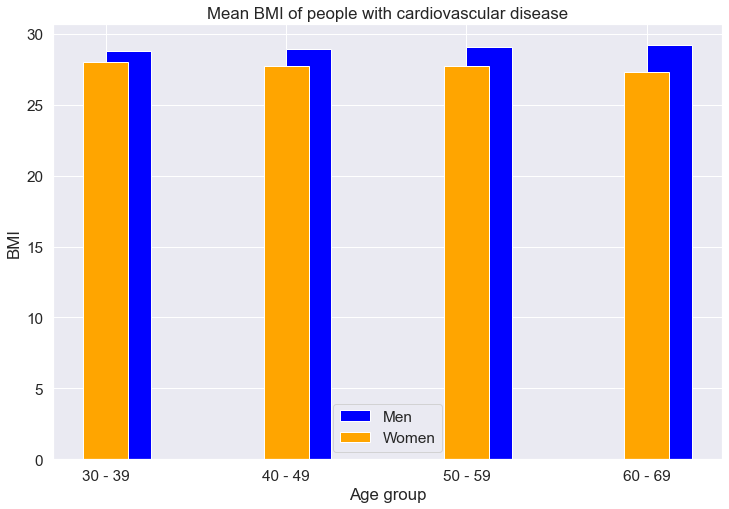

In [38]:
ooo, mmm = separate_data(avg_bmi_age_groups_cardio(df_2.loc[df_2.gender_2 == 1]))

sss, mmm = separate_data(avg_bmi_age_groups_cardio(df_2.loc[df_2.gender_1 == 1]))
plt.subplots(figsize =(12, 8))


plt.bar(mmm, ooo, color = 'blue', width = 0.25, align= 'edge', label = 'Men')
plt.bar(mmm, sss, color = 'orange', width = 0.25, label = 'Women')


plt.ylabel("BMI")
plt.xlabel('Age group')
plt.title('Mean BMI of people with cardiovascular disease')
plt.legend()
plt.show()


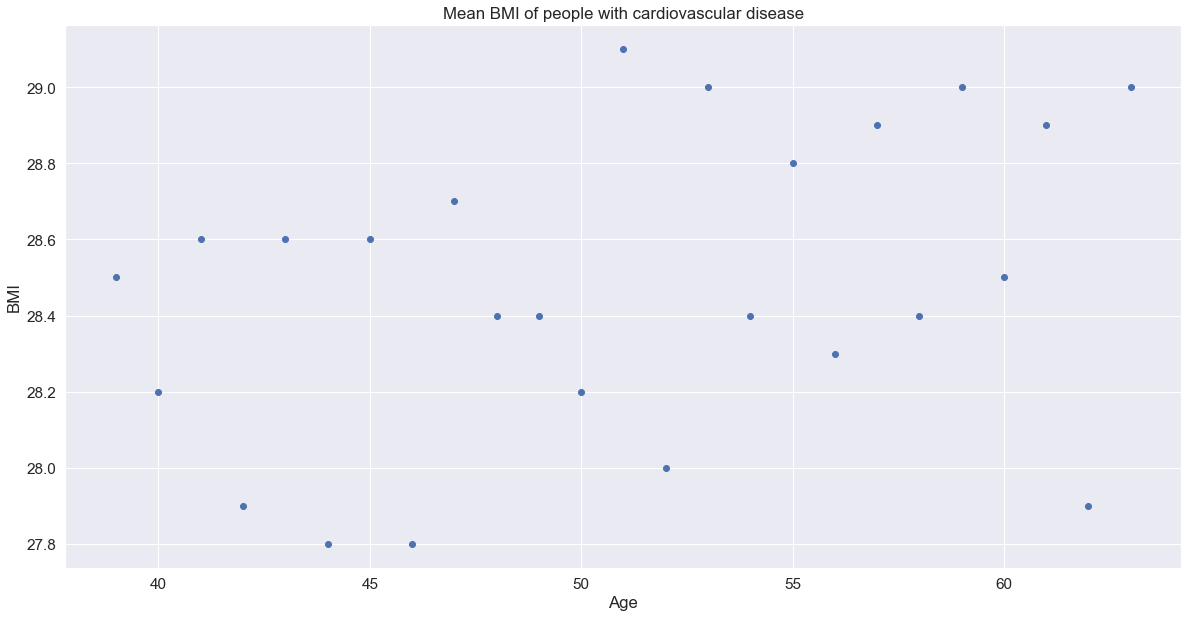

In [39]:
def avg_bmi_all_ages_cardio(df):
    df = df.loc[df.cardio == 1]
    mini = int(df['age'].min())
  
    
    maxi = int(df['age'].max())
    
    results = []

    for i in range(mini, maxi):
        mm = df.loc[df.age == i].BMI.mean()
        results.append([round(mm,1),i])
    return results

aaa, bbb = separate_data(avg_bmi_all_ages_cardio(df_2))
plt.scatter(bbb, aaa)
plt.ylabel("BMI")
plt.xlabel('Age')
plt.title('Mean BMI of people with cardiovascular disease')
# plt.legend()
plt.show()

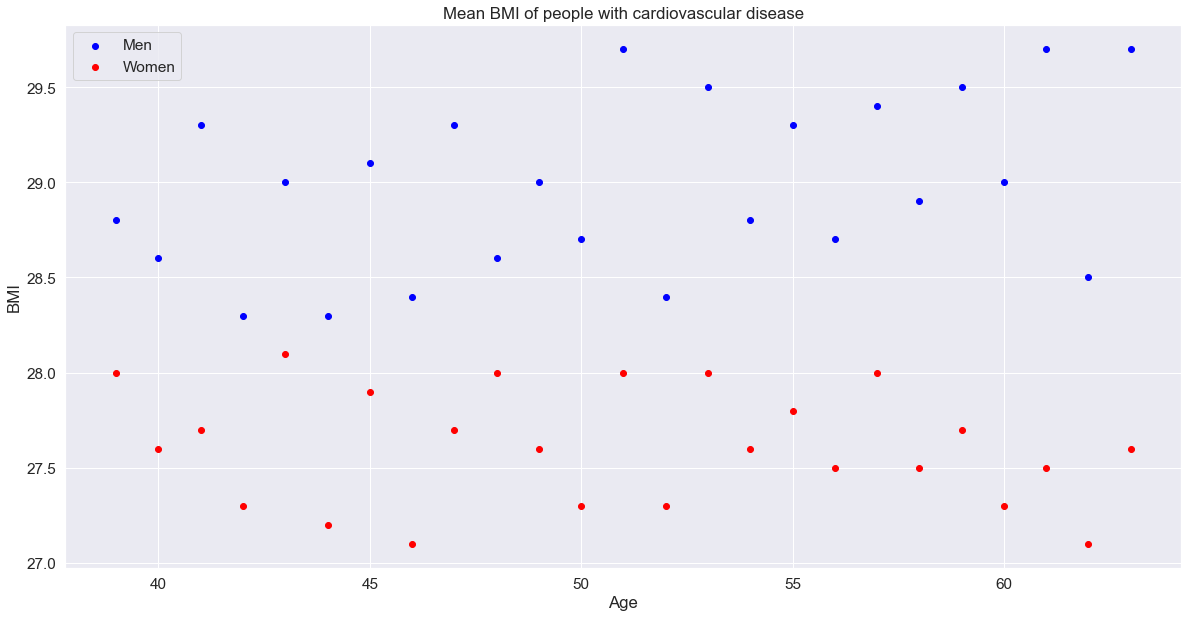

In [40]:
aaa, bbb = separate_data(avg_bmi_all_ages_cardio(df_2.loc[df_2.gender_2 == 1]))
plt.scatter(bbb, aaa, c= 'blue', label = 'Men')
ccc, ddd = separate_data(avg_bmi_all_ages_cardio(df_2.loc[df_2.gender_1 == 1]))

plt.scatter(ddd, ccc, c = 'red', label = 'Women')
# plt.legend()
plt.ylabel("BMI")
plt.xlabel('Age')
plt.title('Mean BMI of people with cardiovascular disease')
plt.legend()
plt.show()

In [41]:
def avg_age_groups_systolic_both(df):
    mini = int(df['age'].min())
    if(mini % 10 != 0):
        mini = int(mini - (mini % 10))
    
    maxi = int(df['age'].max())
    if(maxi % 10 != 0):
        maxi = int(maxi + (10 - (maxi % 10)))
    
    results = []
    for i in range(mini, maxi, 10):
        card = df.loc[df.cardio == 1].loc[df.age >= i].loc[df.age < i + 10 ].ap_hi.mean()
        no_card = df.loc[df.cardio == 0].loc[df.age >= i].loc[df.age < i + 10 ].ap_hi.mean()
        results.append([round(card,1), round(no_card, 1), str(i) + ' - ' + str(i+9)])
    return results
    
def avg_age_groups_diastolic_both(df):
    mini = int(df['age'].min())
    if(mini % 10 != 0):
        mini = int(mini - (mini % 10))
    
    maxi = int(df['age'].max())
    if(maxi % 10 != 0):
        maxi = int(maxi + (10 - (maxi % 10)))
    
    results = []
    for i in range(mini, maxi, 10):
        card = df.loc[df.cardio == 1].loc[df.age >= i].loc[df.age < i + 10 ].ap_lo.mean()
        no_card = df.loc[df.cardio == 0].loc[df.age >= i].loc[df.age < i + 10 ].ap_lo.mean()
        results.append([round(card,1), round(no_card, 1), str(i) + ' - ' + str(i+9)])
    return results

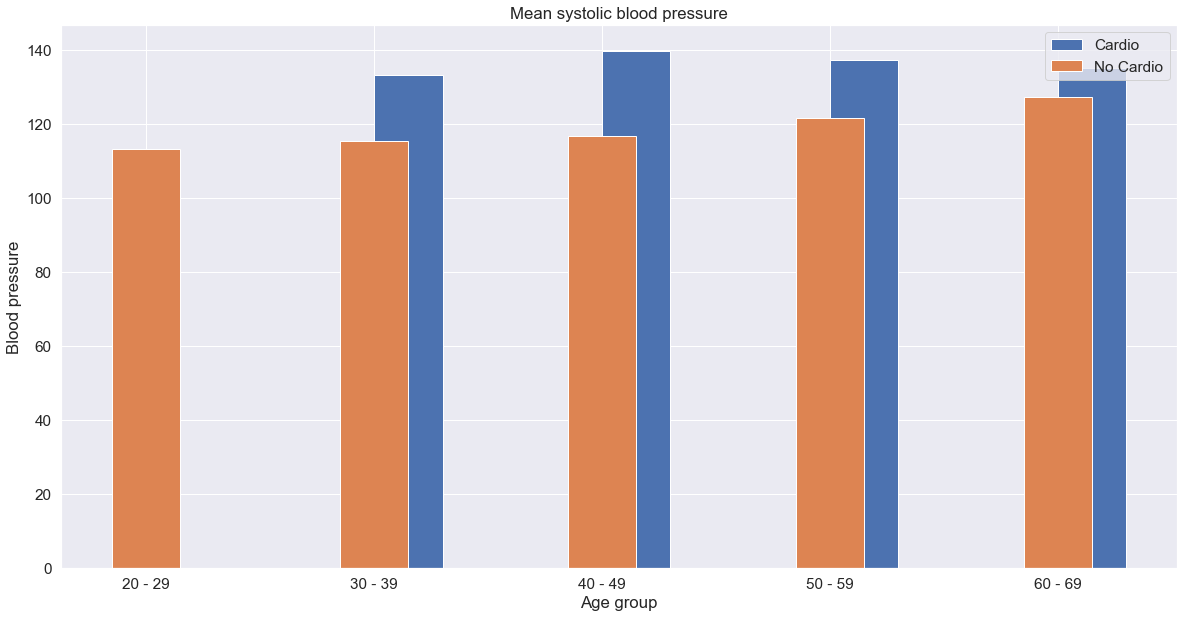

In [42]:
carr, no_carr, sdages = separate_data_3(avg_age_groups_systolic_both(df_2))
plt.bar(sdages, carr, label = 'Cardio', align= 'edge',width = 0.3)
plt.bar(sdages, no_carr, label = 'No Cardio', width = 0.3)
plt.title('Mean systolic blood pressure')
plt.ylabel('Blood pressure')
plt.xlabel('Age group')
plt.legend()
plt.show()

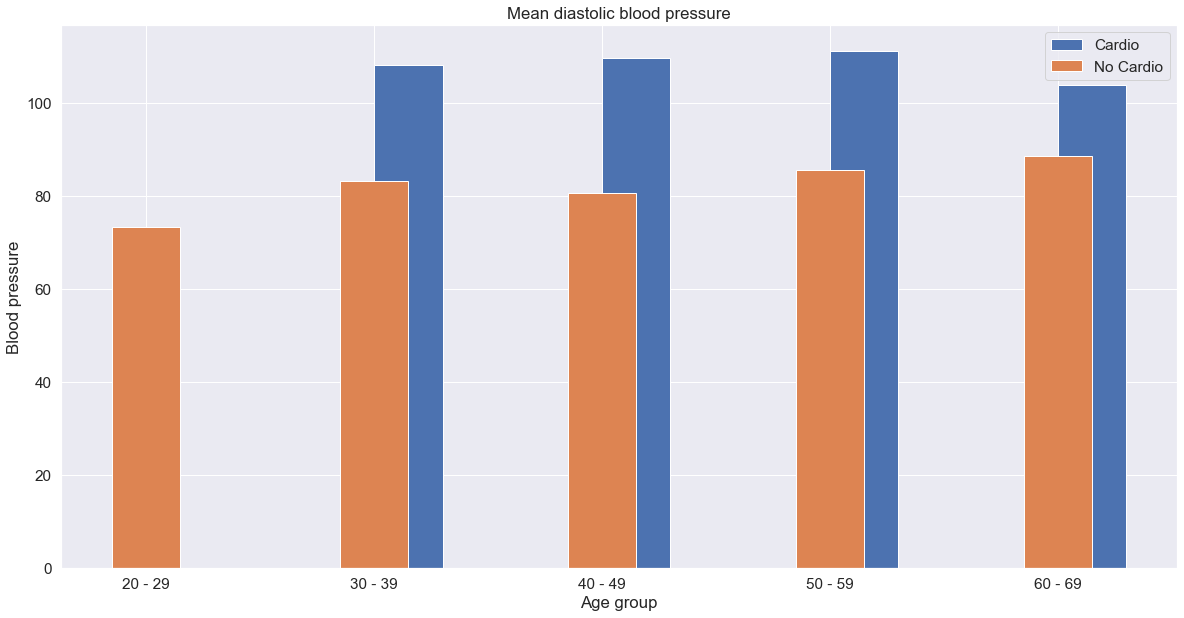

In [43]:
carr, no_carr, sdages = separate_data_3(avg_age_groups_diastolic_both(df_2))
plt.bar(sdages, carr, label = 'Cardio',  align= 'edge',width = 0.3)
plt.bar(sdages, no_carr, label = 'No Cardio',  width = 0.3)
plt.title('Mean diastolic blood pressure')
plt.ylabel('Blood pressure')
plt.xlabel('Age group')
plt.legend()
plt.show()

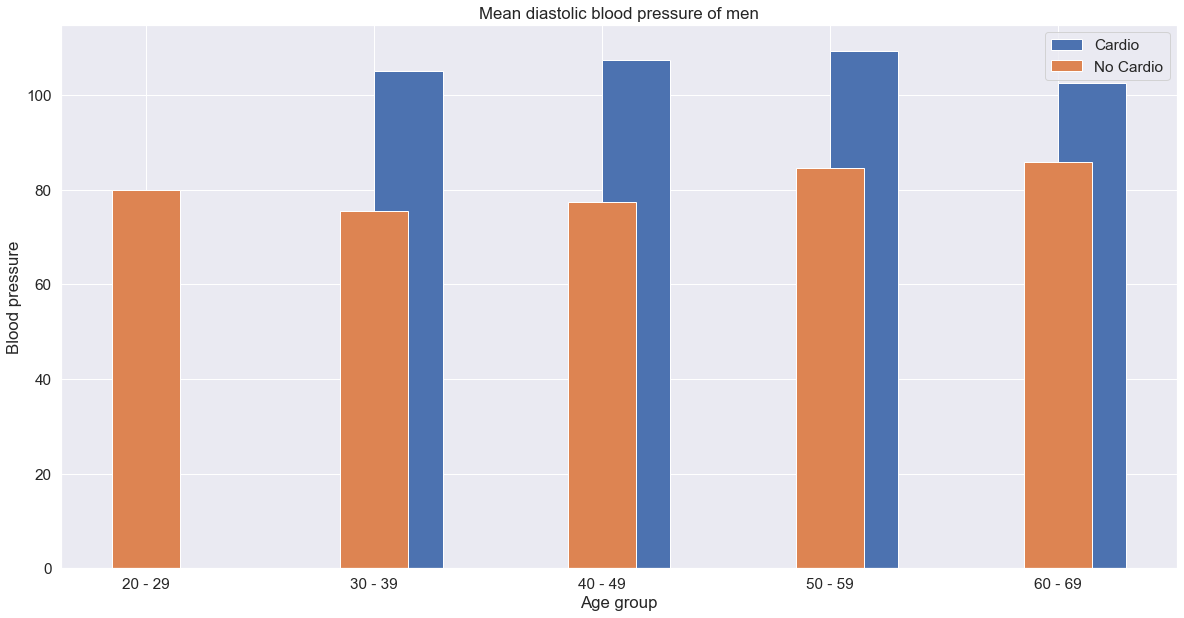

In [44]:
carr, no_carr, sdages = separate_data_3(avg_age_groups_diastolic_both(df_2.loc[df_2.gender_2 == 1]))
plt.bar(sdages, carr, label = 'Cardio',  align= 'edge',width = 0.3)
plt.bar(sdages, no_carr, label = 'No Cardio',  width = 0.3)
plt.title('Mean diastolic blood pressure of men')
plt.ylabel('Blood pressure')
plt.xlabel('Age group')
plt.legend()
plt.show()

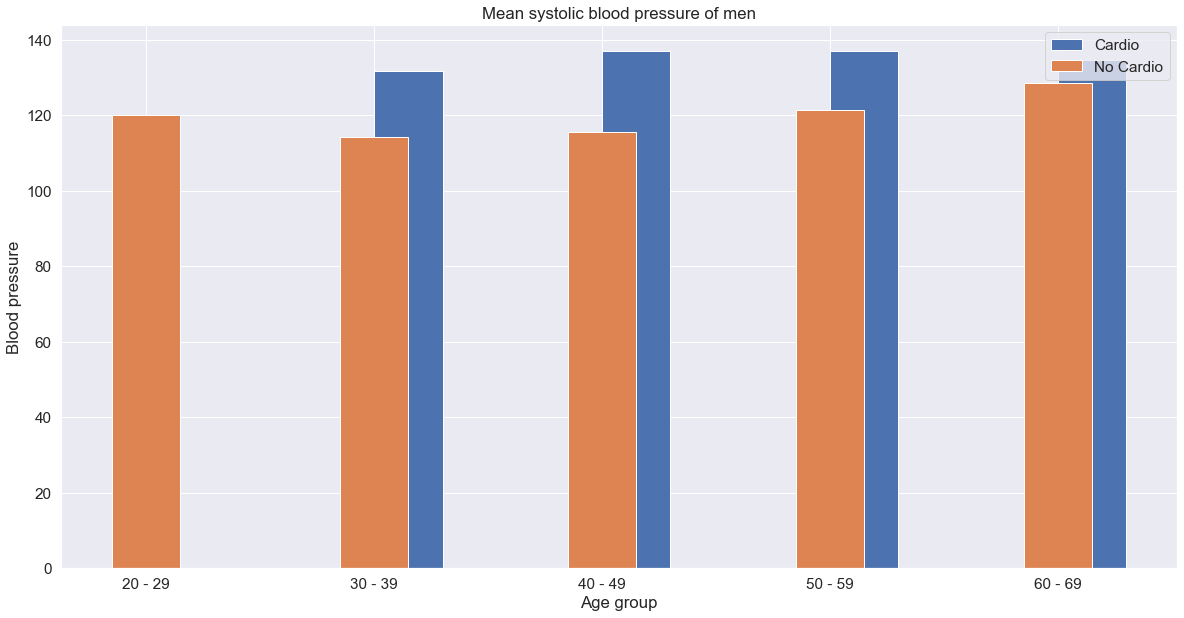

In [45]:
carr, no_carr, sdages = separate_data_3(avg_age_groups_systolic_both(df_2.loc[df_2.gender_2 == 1]))
plt.bar(sdages, carr, label = 'Cardio', align= 'edge',width = 0.3)
plt.bar(sdages, no_carr, label = 'No Cardio', width = 0.3)
plt.title('Mean systolic blood pressure of men')
plt.ylabel('Blood pressure')
plt.xlabel('Age group')
plt.legend()
plt.show()

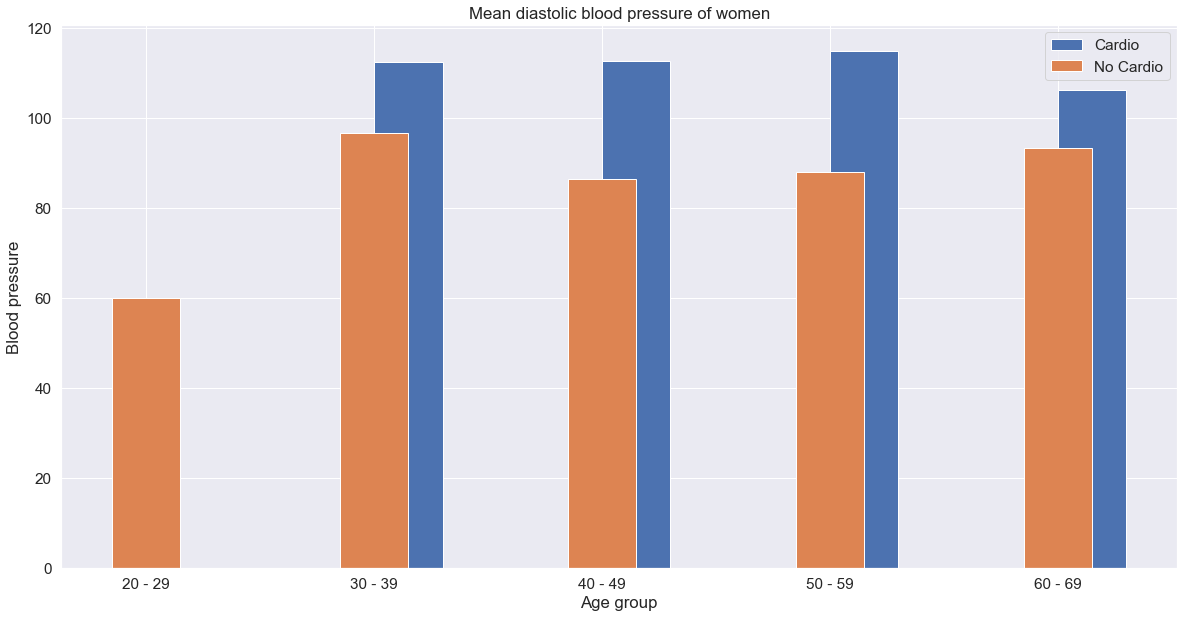

In [46]:
carr, no_carr, sdages = separate_data_3(avg_age_groups_diastolic_both(df_2.loc[df_2.gender_1 == 1]))
plt.bar(sdages, carr, label = 'Cardio',  align= 'edge',width = 0.3)
plt.bar(sdages, no_carr, label = 'No Cardio',  width = 0.3)
plt.title('Mean diastolic blood pressure of women')
plt.ylabel('Blood pressure')
plt.xlabel('Age group')
plt.legend()
plt.show()

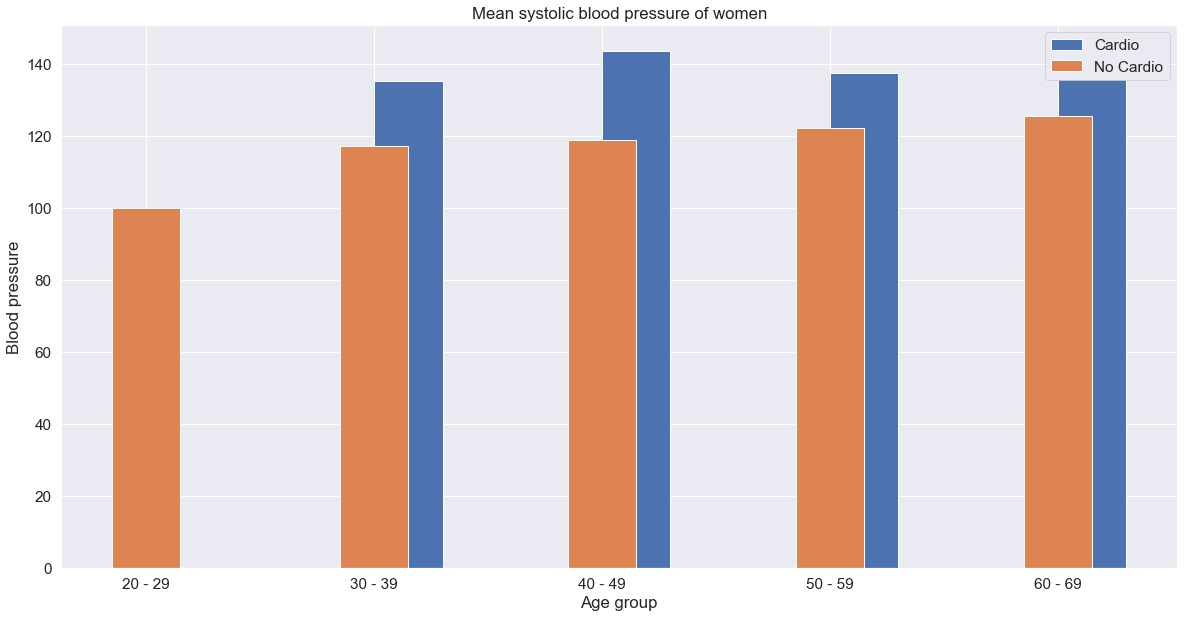

In [47]:
carr, no_carr, sdages = separate_data_3(avg_age_groups_systolic_both(df_2.loc[df_2.gender_1 == 1]))
plt.bar(sdages, carr, label = 'Cardio', align= 'edge',width = 0.3)
plt.bar(sdages, no_carr, label = 'No Cardio', width = 0.3)
plt.title('Mean systolic blood pressure of women')
plt.ylabel('Blood pressure')
plt.xlabel('Age group')
plt.legend()
plt.show()

### Data Preprocessing and Machine Learning

In [50]:
#This code sets the default classfier use for data split testing in the next cell
trees = RandomForestClassifier(n_estimators=25, random_state=42)
fold = KFold(n_splits=5, random_state=42, shuffle=True)

#This code runs a test for the data without polynomial features
X = pd.concat([explncontdf,expln1hotdf],axis=1)
#This creates a version of the dataframe that includes the target
X9 = pd.concat([X,target],axis=1)

predict = cross_val_predict(trees, X, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict)
f1 = f1_score(target, predict, average='weighted')

print(confusion)
print(f1)

#this code tests the baseline against versions with polynomial features added
poly = PolynomialFeatures(1)
#poly2 = PolynomialFeatures(2)
#poly3 = PolynomialFeatures(3)
polydf = pd.DataFrame(poly.fit_transform(explncontdf))

X2 = pd.concat([polydf,expln1hotdf],axis=1)
predict2 = cross_val_predict(trees, X2, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict2)
f1 = f1_score(target, predict2, average='weighted')

print(confusion)
print(f1)

[[24760 10261]
 [10284 24695]]
0.7064999104524738
[[24767 10254]
 [10283 24696]]
0.7066141624322843


In [51]:
#This code searches for the best hyperparameters for the final version of the decision tree model
#param_list = {'n_estimators' : [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]}
#param_list = {'n_estimators' : [100,200,300,400,500,600,700,800,900,1000]}
param_list = {'n_estimators' : [850, 900, 950]}
search = GridSearchCV(trees, param_list, cv=5, n_jobs=-1)
search.fit(X,target)
print(search.best_params_)

In [ ]:
#This code tests the final random forest model without and with polynomial features
trees2 = RandomForestClassifier(n_estimators=950, random_state=42)
predict = cross_val_predict(trees2, X, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict)
f1 = f1_score(target, predict, average='weighted')
print(confusion)
print(f1)

predict2 = cross_val_predict(trees2, X2, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict2)
f1 = f1_score(target, predict2, average='weighted')

print(confusion)
print(f1)

[[25166  9855]
 [10202 24777]]
0.7134635351672255
[[25093  9928]
 [10170 24809]]
0.7128816871192972


In [ ]:
#In this section, data is split between various one hot variables, then the two datasets are each fit to a random forest learning model
#We see the influnce some particular factors have on the accuracy of the model
X2smoke = X2[X2['smoke']==1]
target2 = cardiodf[cardiodf['smoke']==1]
target2 = target2['cardio']
X2nope = X2[X2['smoke']==0]
target3 = cardiodf[cardiodf['smoke']==0]
target3 = target3['cardio']
print("Smoke: yes vs. no")
predict2 = cross_val_predict(trees, X2smoke, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)

predict3 = cross_val_predict(trees, X2nope, target3, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target3, predict3)
f1 = f1_score(target3, predict3, average='weighted')
print(confusion)
print(f1)

X2alco = X2[X2['alco']==1]
target2 = cardiodf[cardiodf['alco']==1]
target2 = target2['cardio']
X2nalco = X2[X2['alco']==0]
target3 = cardiodf[cardiodf['alco']==0]
target3 = target3['cardio']
print("Alcohol: yes vs. no")
predict2 = cross_val_predict(trees, X2alco, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)

predict3 = cross_val_predict(trees, X2nalco, target3, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target3, predict3)
f1 = f1_score(target3, predict3, average='weighted')
print(confusion)
print(f1)

X1gluc = X[X['gluc']==1]
target2 = cardiodf[cardiodf['gluc']==1]
target2 = target2['cardio']
X2gluc = X[X['gluc']==2]
target3 = cardiodf[cardiodf['gluc']==2]
target3 = target3['cardio']
X3gluc = X[X['gluc']==3]
target4 = cardiodf[cardiodf['gluc']==3]
target4 = target4['cardio']
print("Glucose: ok, high, vs very high")
predict2 = cross_val_predict(trees, X1gluc, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)

predict3 = cross_val_predict(trees, X2gluc, target3, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target3, predict3)
f1 = f1_score(target3, predict3, average='weighted')
print(confusion)
print(f1)

predict4 = cross_val_predict(trees, X3gluc, target4, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target4, predict4)
f1 = f1_score(target4, predict4, average='weighted')
print(confusion)
print(f1)

X1chol = X[X['cholesterol']==1]
target2 = cardiodf[cardiodf['cholesterol']==1]
target2 = target2['cardio']
X2chol = X[X['cholesterol']==2]
target3 = cardiodf[cardiodf['cholesterol']==2]
target3 = target3['cardio']
X3chol = X[X['cholesterol']==3]
target4 = cardiodf[cardiodf['cholesterol']==3]
target4 = target4['cardio']
print("Cholesterol: ok, high, vs very high")
predict2 = cross_val_predict(trees, X1chol, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)

predict3 = cross_val_predict(trees, X2chol, target3, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target3, predict3)
f1 = f1_score(target3, predict3, average='weighted')
print(confusion)
print(f1)

predict4 = cross_val_predict(trees, X3chol, target4, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target4, predict4)
f1 = f1_score(target4, predict4, average='weighted')
print(confusion)
print(f1)

X2act = X2[X2['active']==1]
target2 = cardiodf[cardiodf['active']==1]
target2 = target2['cardio']
X2nact = X2[X2['active']==0]
target3 = cardiodf[cardiodf['active']==0]
target3 = target3['cardio']
print("Active: yes vs. no")
nextbest = trees.fit(X2act.values, target2)
predict2 = cross_val_predict(trees, X2act, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)

nextbest = trees.fit(X2nact.values, target3)
predict3 = cross_val_predict(trees, X2nact, target3, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target3, predict3)
f1 = f1_score(target3, predict3, average='weighted')
print(confusion)
print(f1)

X2gen1 = X2[X2['gender_1']==1]
target2 = X9[X9['gender_1']==1]
target2 = target2['cardio']
X2gen2 = X2[X2['gender_1']==0]
target3 = X9[X9['gender_1']==0]
target3 = target3['cardio']
print("Gender 1 vs. Gender 2")
predict2 = cross_val_predict(trees, X2gen1, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)

predict3 = cross_val_predict(trees, X2gen2, target3, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target3, predict3)
f1 = f1_score(target3, predict3, average='weighted')
print(confusion)
print(f1)

print("Double Trouble??")
X2both = X2[X2['smoke']==1]
X2both = X2both[X2both['alco']==1]
target2 = cardiodf[cardiodf['smoke']==1]
target2 = target2[target2['alco']==1]
target2 = target2['cardio']
predict2 = cross_val_predict(trees, X2both, target2, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target2, predict2)
f1 = f1_score(target2, predict2, average='weighted')
print(confusion)
print(f1)


Smoke: yes vs. no
[[2518  722]
 [ 852 2077]]
0.7444669607486671
[[22263  9518]
 [ 9506 22544]]
0.701962749374053
Alcohol: yes vs. no
[[1487  454]
 [ 493 1330]]
0.7482970276030072
[[23326  9754]
 [ 9887 23269]]
0.70346890000531
Glucose: ok, high, vs very high
[[22647  8247]
 [ 8987 19598]]
0.7100653973730725
[[1240  872]
 [ 697 2381]]
0.6953330332856714
[[ 950 1065]
 [ 693 2623]]
0.6622202332145022
Cholesterol: ok, high, vs very high
[[22229  7101]
 [ 8719 14336]]
0.6965670862602673
[[2236 1563]
 [1348 4402]]
0.6935099563652587
[[ 348 1544]
 [ 436 5738]]
0.7138121387390192
Active: yes vs. no
[[20755  7888]
 [ 8302 19316]]
0.7121798556813932
[[4080 2298]
 [2028 5333]]
0.6845608552232465
Gender 1 vs. Gender 2
[[8497 3610]
 [3725 8638]]
0.7002533158380602
[[16300  6614]
 [ 6652 15964]]
0.7086298767183843
Double Trouble??
[[816 214]
 [241 583]]
0.7541283130298531


In [ ]:
from sklearn.svm import SVC

#This code searches for the best parameter for the penalty on the SVC
#param_list = {'C' : [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]}
#param_list = {'C' : [800000, 900000, 1000000, 1100000, 1200000]}
#search = GridSearchCV(model, param_list, cv=5, n_jobs=-1)
#search.fit(X2,target)
#print(search.best_params_)

model = SVC(kernel='rbf', C=1000000, random_state=42)
target = cardiodf['cardio']

#This code tests the final version of the model
model.fit(X,target)
predict2 = cross_val_predict(model, X, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict2)
f1 = f1_score(target, predict2, average='weighted')
print(confusion)
print(f1)


/Users/Sanne/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:960: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Sanne/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:960: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Sanne/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/Sanne/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:

[[26428  8593]
 [10302 24677]]
0.729906478383598


In [ ]:
#This code compares the final model with and without polynomial features included (X without, X2 with)
model = SVC(kernel='rbf', C=1000000, random_state=42)
model.fit(X,target)
predict2 = cross_val_predict(model, X, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict2)
f1 = f1_score(target, predict2, average='weighted')
print(confusion)
print(f1)

model.fit(X2,target)
predict2 = cross_val_predict(model, X2.values, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict2)
f1 = f1_score(target, predict2, average='weighted')
print(confusion)
print(f1)

In [ ]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

#This code checks to see how many principal components are needed to explain the variance in the data
pca = PCA(n_components = 5)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
pca2 = PCA(n_components = 2)
pca2.fit(X)
components = pca2.transform(X)
print(components.shape)

#This code tests a random forest model on the optimal number of components
predict = cross_val_predict(trees, components, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict)
f1 = f1_score(target, predict, average='weighted')
print(confusion)
print(f1)

In [ ]:
from sklearn.cluster import KMeans

#This code tests the unsupervised learning model on 2 clusters
cluster = KMeans(n_clusters=2, random_state=42)
target = cardiodf['cardio']
cluster.fit(X2.values,target)
predict2 = cross_val_predict(cluster, X2.values, target, cv=fold, n_jobs=-1)
confusion = confusion_matrix(target, predict2)
f1 = f1_score(target, predict2, average='weighted')
print(confusion)
print(f1)
